In [1]:
import  os
#set visibile cuda
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'


In [3]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
    
class ConditionalModel(nn.Module):
    def __init__(self, num_classes,x_dim,x_cond_dim):
        super().__init__()
        self.lin1 = ConditionalLinear(x_dim+x_cond_dim, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, x_dim)
    
    def forward(self, x,x_cond, y):
        x = torch.cat([x,x_cond],dim=1)
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [4]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

In [5]:
import os

obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

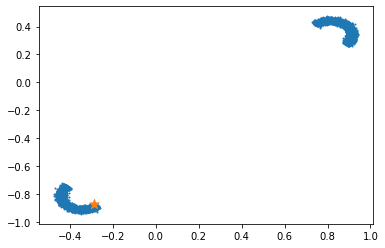

In [6]:

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

In [7]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

 the forward process 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0},(1-\bar{\alpha}_{t})\mathbf{I})
$$


In [49]:
sigma_min = 1e-7
sigma_max = 1e-3

# sigma_min = 1e-5
# sigma_max = 5
n_steps= 100


betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=sigma_min, end=sigma_max)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

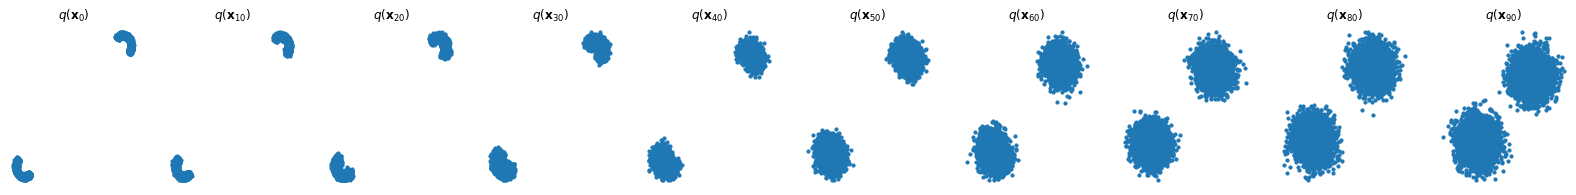

In [50]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(torch.tensor(ref_posterior), torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Reverse process



$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

The two functions defining the mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ can be parametrized by deep neural networks. Note also that these functions are parametrized by $t$, which means that a single model can be used for all time steps.

Ho et al. proposed the following parameterization for the mean function
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

Note that now, the model is trained at outputing directly a form of _noise_ function, which is used in the sampling process. Furthermore, the authors suggest to rather use a fixed variance function

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

This leads to a new sampling procedure for the reverse process as follows.

In [51]:

def p_sample(model, x,x_cond, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x,x_cond,t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)


def p_sample_loop(model,x_cond, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, x_cond, i)
        x_seq.append(cur_x)
    return x_seq

Denoising diffusion probabilistic models (DDPM) training objective


$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$


In [52]:
def noise_estimation_loss(model, x_0,x_cond):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(x_0.device)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(x_0.device)
    e = torch.randn_like(x_0).to(x_0.device)
    # model input
    x = x_0 * a + e * am1
    output = model(x,x_cond, t.to(x_0.device))
    return (e - output).square().mean()

In [53]:
# batch_size = 10000
# from torch.utils.data import TensorDataset
# dataset=TensorDataset(torch.tensor(data).float())
# dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)

In [54]:
model = ConditionalModel(n_steps,x_dim=2,x_cond_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [55]:
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
epochs = 1000
batch_size = 128
for t in range(epochs):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,batch_x_cond)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        # ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss.item())


/tmp/ipykernel_2117821/2381138757.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_2117821/2381138757.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


0.8452374339103699
0.36910808086395264
0.6115827560424805
0.512927770614624
0.3409138321876526
0.6852544546127319
0.437419056892395
0.5460531711578369
0.5665259957313538
0.3673260509967804


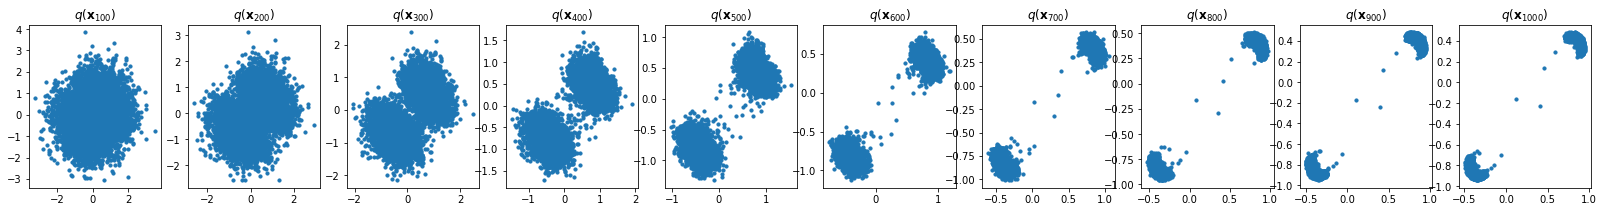

In [56]:
model.to('cpu')
obs_cond=torch.tensor(np.repeat(obs[None,:],dataset.shape[0],axis=0)).float()
x_seq = p_sample_loop(model,obs_cond, dataset.shape)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i * 10].detach()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

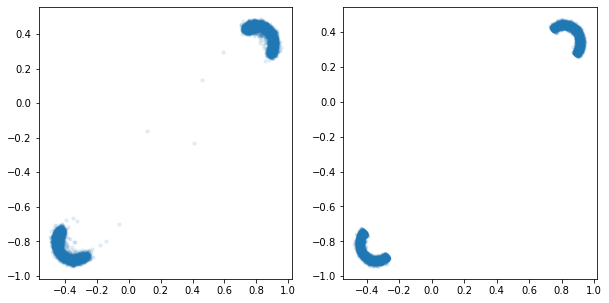

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*x_seq[-1].detach().T, s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.1)


(-1.0, 0.5)

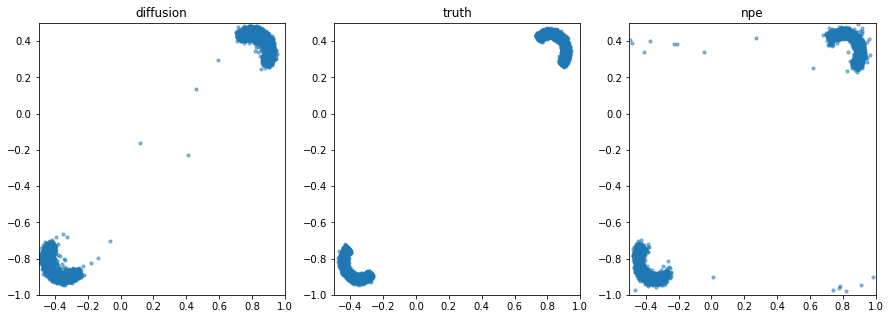

In [58]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(*x_seq[-1].detach().T, s=10, alpha=0.5)
plt.title('diffusion')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)

plt.subplot(1, 3, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.5)
plt.title('truth')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)

nf_re=np.load('nf_twomoon_pos.npy')
plt.subplot(1, 3, 3)
plt.scatter(*nf_re.T, s=10, alpha=0.5)
plt.title('npe')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)